In [1]:
pwd

u'/SNS/users/lj7/notebooks/.rk-work/jnrk-analysis-mcvine-unstable'

In [2]:
# some goodies
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np, os, glob
import histogram.hdf as hh, histogram as H

import mcvine.cli
from mcvine_workflow.DGS import ARCS
from mcvine_workflow import singlextal as sx
from mcvine_workflow.sample import loadSampleYml
from mcvine_workflow.singlextal import io as sxio, coords_transform, dynrange
from mcvine_workflow.singlextal.resolution import use_covmat, use_res_comps

In [3]:
import sys
sys.path.insert(0, "/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/pylib/")
import use_covmat
reload(use_covmat)
print use_covmat.__file__

/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/pylib/use_covmat.pyc


# Generate a series of hkl0 values

Tricky things
* Make sure Ei is consistent with the beam simulation
* Make sure the angles are in correct units

In [4]:
workdir = '/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/9-optimize-4dcovmat-Ei125meV'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/9-optimize-4dcovmat-Ei125meV


# Inputs

## Instrument

ARCS

In [5]:
instrument = use_covmat.instrument(
    name = 'ARCS',
    detsys_radius = "3.*meter",
    L_m2s = "13.6*meter",
    L_m2fc = "11.61*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_covmat.pixel(
    radius = "0.5*inch",
    height = "meter/128",
    pressure = "10*atm",
    )

## Sample

In [6]:
%%file Si.yml
name: Si
chemical_formula: Si2
lattice: 
 constants: 5.490700041, 5.490700041, 5.490700041, 90, 90, 90
 basis_vectors:
  - 5.490700041, 0, 0
  - 0, 5.490700041, 0
  - 0, 0, 5.490700041
 primitive_basis_vectors:
  - 0.0, 2.71526503565, 2.71526503565
  - 2.71526503565, 0.0, 2.71526503565
  - 2.71526503565, 2.71526503565, 0.0
excitations:
  - type: DGSresolution
orientation:
 u: -1, 1, -1
 v: 2, 1, -1
shape: block thickness="1*mm" height="3.*cm" width="3*cm"
temperature: 100*K

Overwriting Si.yml


In [7]:
sample_yml = './Si.yml'

## ** Dynamics parameters

In [8]:
# Ei = 125
q = 0
# E = 20.  # energy transfer

xo = sxio.loadXtalOriFromSampleYml('Si.yml')
# change psi if needed
# xo.psi = np.deg2rad(30.)
# print np.rad2deg(xo.psi)

## Compute hkl0

In [9]:
# Beam simulations by Ricky
!ls /SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams

beam_1000      beam_125_1e9  beam_30	  beam_500_1e9
beam_1000_1e9  beam_250      beam_30_1e9  beam_60
beam_125       beam_250_1e9  beam_500	  beam_60_1e9


# Do One Ei first

In [10]:
Ei = 125.

## Load Es and hkls

In [23]:
Es = np.load("Es.npy")
hkls = np.load("hkls.npy")

## Or calculate them

In [11]:
N_samples = 20
theta_min = -5
theta_max = 120
thetas = np.random.random(N_samples)*(theta_max-theta_min) + theta_min

z_min = -1
z_max = 1.
zs = np.random.random(N_samples)*(z_max-z_min) + z_min

# E_min = -Ei*.95
E_min = 0
E_max = Ei*.95
Es = np.random.random(N_samples)*(E_max-E_min) + E_min

rs = np.ones(N_samples)*3. # radius of the cylinder of the det system
print "z", zs
print "theta", thetas
print 'E', Es

hkl0s = coords_transform.rtzE2hkl(r=rs, theta=np.deg2rad(thetas), z=zs, E=Es, xtalori=xo, Ei=Ei)
print 'hkl0', hkl0s

z [-0.33329559  0.68411572  0.40959453  0.15412231  0.46787441  0.40180618
 -0.3023521   0.28070978 -0.10213087  0.77069565 -0.43928768 -0.80880487
 -0.25601367 -0.93915208  0.78291144  0.15561487  0.12108539 -0.87781867
 -0.22061666 -0.73328625]
theta [  80.17559292  111.76952937  119.72280389    5.56341087   14.25490048
   86.67631483   82.99154773   49.07699459   20.3250388    61.9184521
   13.87558925   82.93255672   52.62101586   25.25336084   94.79062317
  102.67203385   22.71809415   84.27299516   14.63742362   42.41461817]
E [ 104.72353661   14.37780886   22.49160374   62.98459572   60.01578619
   86.27184896   86.01047476  112.54327117   38.88089728   29.92539253
  116.39963903   21.8935766    75.45136574   10.07540829   57.498963
   67.29049446   78.14707715   10.13658639   75.54948244   72.24565296]
hkl0 [[-5.83678654  2.3446478  -2.77151797]
 [-9.97195809  3.89521686 -1.88762028]
 [-9.9800601   4.09072304 -2.91485856]
 [-1.55305058  1.15959923 -0.81272114]
 [-2.18505975  1.

In [12]:
hkl_dir = np.array([0,0,1]) # this could be randomized too
hkls = hkl0s+q*hkl_dir

In [13]:
# hklE array
print np.hstack((hkls, Es[:, np.newaxis]))

[[ -5.83678654e+00   2.34464780e+00  -2.77151797e+00   1.04723537e+02]
 [ -9.97195809e+00   3.89521686e+00  -1.88762028e+00   1.43778089e+01]
 [ -9.98006010e+00   4.09072304e+00  -2.91485856e+00   2.24916037e+01]
 [ -1.55305058e+00   1.15959923e+00  -8.12721137e-01   6.29845957e+01]
 [ -2.18505975e+00   1.26007433e+00  -1.93604139e-01   6.00157862e+01]
 [ -6.84551538e+00   2.62181150e+00  -1.91255531e+00   8.62718490e+01]
 [ -6.70939002e+00   1.85593998e+00  -2.39349928e+00   8.60104748e+01]
 [ -4.42794902e+00   2.59493991e+00  -2.31264660e+00   1.12543271e+02]
 [ -2.46713858e+00  -6.36205463e-02  -2.07454285e-01   3.88808973e+01]
 [ -6.49054599e+00   1.33693791e+00   7.45975232e-01   2.99253925e+01]
 [ -3.27620955e+00   2.57643433e+00  -2.94121731e+00   1.16399639e+02]
 [ -8.31852921e+00  -5.01299000e-02  -2.21913113e+00   2.18935766e+01]
 [ -5.18879850e+00   7.88109108e-01  -1.30196020e+00   7.54513657e+01]
 [ -2.83896690e+00  -1.78099509e+00  -9.68639887e-01   1.00754083e+01]
 [ -8.

** we have not randomize psi angles yet. could be done **

## ** Other parameters

In [14]:
# scan
class psi_scan:
    min = -5
    max = 90.
    step = 1.

# Setup simulations

In [16]:
!rm -rf tmp.use_res_comps/
!mkdir -p tmp.use_res_comps/

In [17]:
hkl_dir

array([0, 0, 1])

In [21]:
np.save("Es.npy", Es)
np.save("hkls.npy", hkls)

In [24]:
%%time
outdir = 'tmp.use_res_comps'
beam = '/SNS/users/p63/ORNL_public_research/MCViNE_Covmat_comparison/mcvine_resolution/beams/beam_125_1e9/'
for E, hkl in zip(Es, hkls):
    print E,hkl
    outdir1 = os.path.join(outdir, 'E%s_hkl%s' % (E, '%s,%s,%s' % tuple(hkl)))
    use_res_comps.setup(outdir1, sample_yml, beam, E, hkl, hkl_dir, psi_scan, instrument, pixel)

104.723536613 [-5.83678654  2.3446478  -2.77151797]
Ei=126.211753632, t0=16.0728240277


/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/solve_psi.py:55: UserWarning: Traceback (most recent call last):
  File "/SNS/software/miniconda2/envs/mcvine-unstable/share/mcvine/workflow/mcvine_workflow/singlextal/solve_psi.py", line 52, in solve
    results.append(solver(res, min, max))
  File "/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/scipy/optimize/zeros.py", line 442, in brentq
    r = _zeros._brentq(f,a,b,xtol,rtol,maxiter,args,full_output,disp)
ValueError: f(a) and f(b) must have different signs

  warnings.warn(tb.format_exc())


Computed:
* psi=-0.642776148583 degree
* Q=[ 7.2015806  -3.14442265  0.34540845]
* hkl2Qmat=[[ -6.50157208e-01   9.41696329e-01   7.71922422e-17]
 [  6.65879860e-01   4.59730571e-01  -8.09165116e-01]
 [ -6.65879860e-01  -4.59730571e-01  -8.09165116e-01]]
* ki=7.80444915794
* vectors ki=[ 7.80444916  0.          0.        ], kf=[ 0.60286856  3.14442265 -0.34540845]
These two numbers should be very close:
  104.723536613
  104.723536613
  Ei=126.211753632, Ef=21.4882170186
* Ef=21.4882170186
* pixel positon=[ 0.56489024  2.94633654 -0.32364909]
* pixel_position=[ 0.56489024  2.94633654 -0.32364909]
t_m2s=0.00278375914959, t_s2p=0.0014882012053, t_m2p=0.00427196035489
14.3778088605 [-9.97195809  3.89521686 -1.88762028]
Ei=126.211753632, t0=16.0728240277
Computed:
* psi=-0.431245847425 degree
* Q=[ 10.35879864  -6.69381136  -1.62447712]
* hkl2Qmat=[[-0.65362942  0.9392896   0.        ]
 [ 0.66417805  0.46218579 -0.80916512]
 [-0.66417805 -0.46218579 -0.80916512]]
* ki=7.80444915794
* vecto

Ei=126.211753632, t0=16.0728240277
Computed:
* psi=-0.341198049922 degree
* Q=[ 4.78586519 -3.90026734  0.41579038]
* hkl2Qmat=[[ -6.55104827e-01   9.38261177e-01  -7.74748576e-17]
 [  6.63450841e-01   4.63229065e-01  -8.09165116e-01]
 [ -6.63450841e-01  -4.63229065e-01  -8.09165116e-01]]
* ki=7.80444915794
* vectors ki=[ 7.80444916  0.          0.        ], kf=[ 3.01858397  3.90026734 -0.41579038]
These two numbers should be very close:
  75.4513657392
  75.4513657392
  Ei=126.211753632, Ef=50.7603878928
* Ef=50.7603878928
* pixel positon=[ 1.83614766  2.37245901 -0.25291744]
* pixel_position=[ 1.83614766  2.37245901 -0.25291744]
t_m2s=0.00278375914959, t_s2p=0.000966105506568, t_m2p=0.00374986465616
10.075408287 [-2.8389669  -1.78099509 -0.96863989]
Ei=126.211753632, t0=16.0728240277
Computed:
* psi=-0.121694671218 degree
* Q=[ 1.33249986 -3.03491637  2.22490871]
* hkl2Qmat=[[ -6.58694542e-01   9.35744554e-01  -7.76832211e-17]
 [  6.61671320e-01   4.65767378e-01  -8.09165116e-01]
 [ 

In [25]:
ls tmp.use_res_comps/

E10.075408287_hkl-2.8389668997,-1.78099509115,-0.968639887052/
E10.1365863868_hkl-8.6319756999,-0.269674599908,-2.31431655406/
E104.723536613_hkl-5.83678654446,2.34464780483,-2.77151797418/
E112.543271174_hkl-4.42794902323,2.59493990628,-2.312646603/
E116.399639027_hkl-3.27620954903,2.57643433106,-2.9412173071/
E14.3778088605_hkl-9.97195809068,3.89521686071,-1.88762027578/
E21.8935765999_hkl-8.31852920577,-0.0501298999688,-2.2191311332/
E22.4916037416_hkl-9.98006010048,4.09072303876,-2.91485856234/
E29.9253925295_hkl-6.49054599033,1.33693791339,0.745975232362/
E38.8808972845_hkl-2.46713858249,-0.0636205463063,-0.207454284642/
E57.4989629954_hkl-8.07798603817,3.07856516351,-1.2974388675/
E60.0157861876_hkl-2.18505974771,1.2600743333,-0.193604139311/
E62.984595718_hkl-1.55305058429,1.15959923154,-0.812721137242/
E67.2904944562_hkl-8.17074902663,2.83646060497,-2.49860959041/
E72.2456529617_hkl-4.45176891725,0.173208435347,-1.65380194261/
E75.4513657392_hkl-5.18879850427,0.788109107908,-1.

In [26]:
subdirs = glob.glob("./tmp.use_res_comps/E*_hkl*")

In [27]:
%%time
for subdir in subdirs:
    cmd = 'cd %s; python run.py' % subdir
    print cmd
    if os.system(cmd):
        print "%r failed" % cmd
    continue

cd ./tmp.use_res_comps/E62.984595718_hkl-1.55305058429,1.15959923154,-0.812721137242; python run.py
cd ./tmp.use_res_comps/E75.5494824388_hkl-2.41879229338,0.879729872691,-1.32250835907; python run.py
cd ./tmp.use_res_comps/E60.0157861876_hkl-2.18505974771,1.2600743333,-0.193604139311; python run.py
cd ./tmp.use_res_comps/E112.543271174_hkl-4.42794902323,2.59493990628,-2.312646603; python run.py
cd ./tmp.use_res_comps/E57.4989629954_hkl-8.07798603817,3.07856516351,-1.2974388675; python run.py
cd ./tmp.use_res_comps/E10.075408287_hkl-2.8389668997,-1.78099509115,-0.968639887052; python run.py
cd ./tmp.use_res_comps/E14.3778088605_hkl-9.97195809068,3.89521686071,-1.88762027578; python run.py
cd ./tmp.use_res_comps/E67.2904944562_hkl-8.17074902663,2.83646060497,-2.49860959041; python run.py
cd ./tmp.use_res_comps/E72.2456529617_hkl-4.45176891725,0.173208435347,-1.65380194261; python run.py
cd ./tmp.use_res_comps/E86.2718489567_hkl-6.84551537521,2.62181150357,-1.91255530962; python run.py
c

In [28]:
def computeMcvineCovMat(outdir1):
    dhkls = np.load('%s/dhkls.npy' % outdir1)
    dEs = np.load('%s/dEs.npy' % outdir1)
    probs = np.load('%s/probs.npy' % outdir1)
    dhs,dks,dls = dhkls.T
    dhs_np = np.array(dhs)
    dks_np = np.array(dks)
    dls_np = np.array(dls)
    dEs_np = np.array(dEs)
    mask = (dhs_np> -2.)*(dhs_np<2.) \
        * (dks_np> -2.)*(dks_np<2.) \
        * (dls_np> -2.)*(dls_np<2.) 
    Data = np.array([dhs_np[mask], dks_np[mask], dls_np[mask], dEs_np[mask]])
    return np.cov(Data, aweights=probs[mask])

In [29]:
use_covmat

<module 'use_covmat' from '/SNS/users/lj7/simulations/ARCS/resolution-fit-covmat/pylib/use_covmat.pyc'>

In [30]:
Ei=126.

In [31]:
mcvine_cms = {}
for subdir in subdirs:
    dirname = os.path.basename(subdir)
    E, hkl = map(eval, dirname.lstrip('E').split('_hkl'))
    print E,hkl
    mcvine_cms[(E,hkl)] = computeMcvineCovMat(subdir)
    continue

62.984595718 (-1.55305058429, 1.15959923154, -0.812721137242)
75.5494824388 (-2.41879229338, 0.879729872691, -1.32250835907)
60.0157861876 (-2.18505974771, 1.2600743333, -0.193604139311)
112.543271174 (-4.42794902323, 2.59493990628, -2.312646603)
57.4989629954 (-8.07798603817, 3.07856516351, -1.2974388675)
10.075408287 (-2.8389668997, -1.78099509115, -0.968639887052)
14.3778088605 (-9.97195809068, 3.89521686071, -1.88762027578)
67.2904944562 (-8.17074902663, 2.83646060497, -2.49860959041)
72.2456529617 (-4.45176891725, 0.173208435347, -1.65380194261)
86.2718489567 (-6.84551537521, 2.62181150357, -1.91255530962)
21.8935765999 (-8.31852920577, -0.0501298999688, -2.2191311332)
86.0104747578 (-6.70939001599, 1.85593997555, -2.39349928162)
75.4513657392 (-5.18879850427, 0.788109107908, -1.30196020451)
104.723536613 (-5.83678654446, 2.34464780483, -2.77151797418)
29.9253925295 (-6.49054599033, 1.33693791339, 0.745975232362)
78.1470771452 (-3.01670530898, 1.17134546073, -0.934349699278)
38.88

# Optimization

In [32]:
def computeCovMat(E, hkl, tau_P, tau_M, pix_r, pix_h, sample_thickness, sigma_thetai, sigma_phii):
    tofwidths = use_covmat.tofwidths(P=tau_P, M=tau_M)
    beamdivs = use_covmat.beamdivs(theta=sigma_thetai, phi=sigma_phii)
    samplethickness = sample_thickness
    instrument = use_covmat.instrument(
        name = 'ARCS',
        detsys_radius = "3.*meter",
        L_m2s = "13.6*meter",
        L_m2fc = "11.61*meter",
        offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
        )
    pixel = use_covmat.pixel(
        radius = "%s*inch" % pix_r,
        height = "meter*%s" % pix_h,
        pressure = "10*atm",
        )
    class dynamics:
        hkl_dir = np.array([1.,0.,0.])
        dq = 0
    dynamics.hkl0 = hkl
    dynamics.E = E
    cm_res = use_covmat.compute(
        sample_yml, Ei, dynamics, psi_scan,
        instrument, pixel,
        tofwidths, beamdivs, samplethickness,
        plot=False)
    # ellipsoid_trace = cm_res['u']
    InvCov4D = cm_res['InvCov4D']
    return np.linalg.inv(InvCov4D)

def cost(tau_P, tau_M, pix_r, pix_h, sample_thickness, sigma_thetai, sigma_phii):
    r = 0.
    for subdir in subdirs:
        dirname = os.path.basename(subdir)
        E, hkl = map(eval, dirname.lstrip('E').split('_hkl'))
        mcvine_cm = mcvine_cms[(E,hkl)]
        cm = computeCovMat(E, hkl, tau_P, tau_M, pix_r, pix_h, sample_thickness, sigma_thetai, sigma_phii)
        # diff = (mcvine_cm - cm)/(np.abs(mcvine_cm)+1e-6)
        # r+= np.sum(diff*diff)
        diff_mat = cm - mcvine_cm
        lambdas, eigvecs = np.linalg.eig(diff_mat)
        uniform_norm = max(np.fabs(lambdas))
        r+=uniform_norm
        continue
    rt = r/len(subdirs)
    print rt
    return rt

In [33]:
cost(10, 8, 0.5, 1./128, 0.001, 0.01, 0.01)

3.22119667111


3.2211966711101838

In [34]:
cost(11.2874, 6.9908, 0.4406349, 0.00282439, 0.00416829188, 0.002070546, 0.011458927)

2.36102589197


2.3610258919687781

In [35]:
import scipy.optimize

In [36]:
_ = lambda x: cost(*x)
x0 = 10, 8, 0.5, 1./128, 0.001, 0.01, 0.01

## Tried unbounded optimizations here

In [42]:
optimized = scipy.optimize.minimize(_, x0)

2.61917908032
2.61917908085
2.61917908653
2.61917916263
2.61917909252
2.61917911032
2.61917908159
2.61917908153
2.61917908032
160.668873236
160.668873236
160.668873241
160.668873248
160.668873106
160.668872874
160.668859405
160.668873235
160.668873235
2.55715559657
2.55715559657
2.5571555967
2.55715560208
2.55715566677
2.55715560289
2.55715544538
2.55715559671
2.55715559682
2.43850137895
2.43850137895
2.43850137902
2.43850138437
2.43850144469
2.43850138138
2.43850127439
2.43850137908
2.43850137908
2.39306614963
2.39306614963
2.39306614999
2.39306615551
2.39306621262
2.3930662549
2.3930660742
2.39306615121
2.39306615197
2.36421768554
2.36421768554
2.36421768558
2.36421769089
2.3642177464
2.36421772786
2.36421759837
2.36421768569
2.36421768568
2.22181853889
2.22181853889
2.22181853878
2.22181854396
2.22181859229
2.22181857599
2.22181847068
2.22181853494
2.22181853461
27.3454343569
27.3454343569
27.3454343623
27.3454343688
27.3454344395
27.3454344098
27.3454343537
27.3454421777
27.3454444

0.813910118159
0.813910120304
0.813910121362
0.813910085967
0.813910093274
0.813671571578
0.813671571578
0.813671572369
0.813671572119
0.813671568061
0.813671571966
0.813671577315
0.813671522675
0.813671528261
0.813217915121
0.813217915121
0.813217915825
0.813217915606
0.813217911915
0.813217915106
0.81321792037
0.813217871314
0.813217876883
0.812640412709
0.812640412709
0.812640412841
0.812640412835
0.812640411409
0.812640412436
0.812640414411
0.812640403864
0.812640398484
0.812255472897
0.812255472897
0.812255473811
0.812255473561
0.812255469106
0.812255472088
0.812255481537
0.812255432524
0.81225542718
0.811979424852
0.811979424852
0.811979424847
0.811979424982
0.811979423794
0.811979424526
0.811979427611
0.811979424414
0.811979420603
0.811772569231
0.811772569231
0.811772569287
0.811772569386
0.811772568127
0.811772568998
0.81177257221
0.811772566358
0.811772562166
0.811573543514
0.811573543514
0.811573544044
0.811573543956
0.81157354115
0.811573543441
0.811573549905
0.811573522742

0.808885336779
0.808885335607
0.808885335212
0.808885339272
0.808885336564
0.808885336564
0.808885336642
0.808885336676
0.808885336644
0.808885336706
0.808885335607
0.808885335212
0.808885339247
0.808885336564
0.808885336564
0.808885336642
0.808885336676
0.808885336644
0.808885336706
0.808885335607
0.808885335212
0.808885339247
0.808885336564
0.808885336564
0.808885336642
0.808885336678
0.808885336644
0.808885336707
0.808885335607
0.808885335212
0.808885339249
0.808885336564
0.808885336564
0.808885336642
0.808885336676
0.808885336644
0.808885336706
0.808885335607
0.808885335212
0.808885339247
0.808885336564
0.808885336564
0.808885336642
0.808885336676
0.808885336644
0.808885336706
0.808885335607
0.808885335212
0.808885339247
0.808885336564
0.808885336564
0.808885336642
0.808885336678
0.808885336644
0.808885336707
0.808885335607
0.808885335211
0.808885339247
0.808885336564
0.808885336564
0.808885336642
0.808885336676
0.808885336644
0.808885336706
0.808885335607
0.808885335212
0.80888533

0.808885336676
0.808885336644
0.808885336706
0.808885335607
0.808885335212
0.808885339247
0.808992096576
0.80889749529
0.808888105534
0.808886168135
0.808885616446
0.808885435011
0.808885371743
0.8088853493
0.808885341229
0.8088853383
0.808885337279
0.808885336757


In [43]:
optimized

      fun: 0.8088853365635122
 hess_inv: array([[  5.51699295e-01,  -1.15124956e+00,   2.23190600e-02,
          2.26605599e-02,  -2.50732742e-03,   1.53871397e-02,
         -1.06758873e-02],
       [ -1.15124956e+00,   7.86830560e+00,   6.79146632e-01,
         -1.50216978e-01,   7.04561604e-03,  -7.36557601e-02,
          1.08129259e-01],
       [  2.23190600e-02,   6.79146632e-01,   1.69726789e-01,
         -1.35173090e-02,   8.46555205e-04,   2.73576420e-04,
          8.81768231e-03],
       [  2.26605599e-02,  -1.50216978e-01,  -1.35173090e-02,
          1.41234775e-02,   1.41047142e-05,   1.49339460e-03,
         -1.96528272e-03],
       [ -2.50732742e-03,   7.04561604e-03,   8.46555205e-04,
          1.41047142e-05,   4.07669744e-04,  -1.22738749e-04,
          1.34791764e-04],
       [  1.53871397e-02,  -7.36557601e-02,   2.73576420e-04,
          1.49339460e-03,  -1.22738749e-04,   1.53584825e-03,
         -1.36563852e-03],
       [ -1.06758873e-02,   1.08129259e-01,   8.81768

In [27]:
optimized

      fun: 5.656648038588771
 hess_inv: array([[  1.04221830e-05,  -5.48073052e-05,   1.83342320e-05,
         -1.31495411e-05,   1.60783438e-04,   9.88104463e-06,
         -6.04459094e-05],
       [ -5.48073052e-05,   5.57253708e-04,  -2.37411390e-04,
          1.62500195e-04,  -1.76243160e-03,  -1.38302589e-04,
          6.92478703e-04],
       [  1.83342320e-05,  -2.37411390e-04,   1.07136273e-04,
         -7.11413084e-05,   7.69893521e-04,   5.97606702e-05,
         -3.05132838e-04],
       [ -1.31495411e-05,   1.62500195e-04,  -7.11413084e-05,
          5.29108027e-05,  -5.10377674e-04,  -4.90208395e-05,
          2.00523968e-04],
       [  1.60783438e-04,  -1.76243160e-03,   7.69893521e-04,
         -5.10377674e-04,   5.67523509e-03,   4.15390934e-04,
         -2.23883676e-03],
       [  9.88104463e-06,  -1.38302589e-04,   5.97606702e-05,
         -4.90208395e-05,   4.15390934e-04,   5.30740894e-05,
         -1.63444266e-04],
       [ -6.04459094e-05,   6.92478703e-04,  -3.051328

In [44]:
optimized.x

array([  1.70442970e+01,   4.92485268e+00,  -1.38743124e-02,
         1.08797394e-04,   1.93109288e-03,  -2.69548144e-02,
        -2.67137674e-02])

In [37]:
x0

(10, 8, 0.5, 0.0078125, 0.001, 0.01, 0.01)

# Use differential evolution and bounded optimization

tau_P, tau_M, pix_r, pix_h, sample_thickness, sigma_thetai, sigma_phii

In [45]:
_ = lambda x: cost(*x)
x0 = 10, 8, 0.5, 1./128, 0.001, 0.01, 0.01
optimized = scipy.optimize.differential_evolution?

In [37]:
bounds = [1, 50], [1, 50], [0.1, 1.], [1./1000, 1./50], [1e-6, 0.01], [1e-6, 0.1], [1e-6, 0.1]
optimized = scipy.optimize.differential_evolution(_, bounds)

9.53609005716
95.0001554907
61.1569724504
71.5350795711
45.2060934327
125.476976875
68.0408810644
33.8121563491
141.664548498
16.1101550855
49.3941549764
12.9715188267
6.71878467623
107.509018509
55.7333033018
179.181219347
110.084845709
24.336228815
61.2291217331
39.4919397666
114.199841398
20.960819524
88.8967527275
66.7928206691
165.105259277
48.6216821869
191.910666843
15.2608152267
50.3869624495
147.558125696
116.170366369
90.2553236711
55.5520828076
73.8125305446
76.5217648193
61.2806571506
8.28709103743
38.5991650526
143.1311878
141.332929953
9.62935798069
100.836094657
9.56020567159
2.22787096895
13.7128874772
19.8396813478
84.1583432665
17.3266975103
37.1577202823
42.3671000521
45.0598569011
65.0699491842
25.9248358884
140.160306768
4.67338022071
14.8810064417
88.303509794
74.9939335222
84.3223146686
55.6536932486
57.6746681899
84.1815757425
83.5567101947
80.1556851773
10.1207766285
67.8867104486
110.406029638
8.20570381872
81.4452481317
135.173174147
16.1243315947
39.82885470

9.3304943145
29.9767419713
5.25911400782
6.74686716588
3.01930452321
24.8148563054
2.55303589481
7.28800077294
8.42886603833
5.40027662726
4.2522264434
2.44712952035
3.5764111121
3.08907848866
14.8379206188
0.880653209197
3.0781874288
5.15376720313
15.2723982648
4.00900545106
1.33348504412
1.04406938007
0.819876495654
1.57466763667
9.35564010989
10.6690717056
20.6662448105
3.49477368732
4.93162525052
2.98259935455
3.431065946
10.5954110411
13.2050745114
2.36527582006
1.23019626326
2.3927261803
22.6687820966
2.61528510118
7.34255018847
7.90592219625
45.8007985974
4.15795334507
20.3343182715
20.9579493361
25.0490402859
2.6451267339
6.90768406909
11.1195441775
27.4502654032
112.232896184
4.1801846515
7.50844643713
28.4837433799
9.10970944183
18.8331747123
98.5223608005
2.15842554148
3.31447354052
11.6448822261
3.37085197323
11.5005184043
4.43660779891
1.32040571646
2.09644970202
4.14133983848
0.731075108459
7.18291280696
28.9539536131
31.8673278209
58.4158760862
36.3459019429
26.919981338

2.71203708839
2.76932372178
8.23580880126
19.6095578504
16.5467470847
9.2577510451
11.6057982145
2.10798612997
21.5682735142
46.329606297
3.6466262985
2.83775037983
10.3409140488
17.082727833
1.98550177467
11.799713798
0.794810808279
1.95636846629
1.4668268182
1.19604265188
8.65714592771
16.0420865089
0.563717688253
2.13386204054
2.47901760019
1.46540201443
4.96266401915
0.604528330451
61.2990423986
3.41504922521
80.2158407901
20.1427885788
0.841442264435
144.72104676
7.63357000986
152.094252682
20.8857736398
0.727456877766
13.126113601
1.67165614941
13.7648232145
1.72985224749
9.47048786754
0.984757235575
13.9514107466
1.71973656889
76.4173904289
5.34284068783
2.6062205561
1.63104975755
76.3919305947
9.22160370803
0.571335457845
64.6932673956
12.8783989562
120.98465156
2.05122074798
2.37427115871
2.9284366902
17.7291873702
146.564768776
1.16886172429
2.1072678936
4.05394659916
4.32165203041
0.519064684194
26.2630193273
66.9793323164
15.3923793607
1.01351084915
92.4202640238
103.578676

77.3148111752
1.50351980154
2.21359120754
1.67313757523
1.95727819525
1.91803773446
122.324066513
56.9178063019
3.38787127966
0.454007437373
0.854444671854
6.92293868982
1.59665959205
27.0620225583
0.403880476722
8.2925294127
8.90968218092
2.4284525757
0.780092518437
1.43824389356
2.59263085131
17.6069727175
2.95765146425
7.36709391011
1.06579389837
4.09188155003
64.2117300874
33.5652735905
0.555449169141
28.0749509504
1.4217944836
10.7392552078
3.28352364765
0.511835094697
2.02790491663
5.14548919366
1.92502753678
0.630404385096
8.38982900413
5.42308690249
3.43839811183
4.75324131439
1.09008070031
2.0211338808
34.6713817845
2.25123503699
1.94321443092
0.852438111224
148.48569672
0.821846607398
2.22464242632
7.75171029422
4.82910215672
1.08473340296
1.26387066568
0.855245547604
143.029061612
2.76936647147
9.18876931408
75.3974312155
36.4893432073
8.84019918473
3.61167962514
80.9351755759
2.67795638421
57.383691445
0.812409081069
133.813241865
2.66272069545
9.33086737521
1.09792835853
3

113.333694947
4.60414826855
0.824784433685
3.34289075628
0.892413451101
45.2706800246
95.3424406467
0.842775145492
1.44388408124
4.70137612812
3.99334071711
1.51199256288
44.6738062994
43.8333162793
0.534685681124
0.645819477213
1.26991917739
0.641515493195
0.859278948228
20.137233622
0.777367759594
77.005054898
16.7105339767
4.41766015938
1.86931599144
0.854474977843
1.23525133084
4.25948929435
1.91019899693
1.24408039118
2.008133848
2.73772343428
0.568604726728
31.0477819202
2.24510643895
126.246977678
127.015149772
3.69551105336
8.78639831491
11.5397991741
0.591516869713
0.480319023671
3.68520124431
1.17466366948
0.467014381448
1.55520702792
2.30013417957
16.530806032
8.61625692067
55.4401341014
2.95379608686
1.14648064973
99.0277495217
7.64657967479
8.40325456389
50.7057273077
17.7675346466
1.95489030169
0.663486114683
31.1738747456
1.11250632946
1.9362705189
0.691126792948
127.214114402
0.911350415104
1.06042449066
0.542237587717
1.00947911092
0.619535177529
1.30557726048
2.067529

0.672075892035
2.33090125381
0.651492601243
5.74382223005
10.3904487471
92.5816823977
5.30442830447
1.01315545089
126.313338955
0.545386522004
0.459759005503
0.859572985508
1.08339040755
5.74478567434
0.643643679961
3.15554332786
0.754898932825
13.2285897788
1.14396541672
0.876404002895
129.901936028
1.28401950627
0.554221196438
0.688680789243
48.1362835915
1.40529255005
98.6880943346
0.885180679764
112.497053256
66.7172443238
1.23610032107
0.746748331004
1.0356581912
0.951279706505
1.90720580858
1.61804924824
39.6850981671
2.07242524037
0.781586697198
144.646150418
0.890476580411
32.5486535841
1.01294862476
3.31475624185
0.519556388302
0.9227956697
0.433244335116
2.15410071992
0.659389069499
96.9243639135
1.55462528027
2.72051239387
1.7296125754
144.274059724
0.407900629464
6.98817928902
117.420866066
0.55557185307
0.793794480972
0.641672721777
1.51542935293
2.51744090279
0.89564588988
2.04744368964
0.427442981618
1.33658882492
7.15497897908
2.4729043161
1.46253121415
3.51342786659
2.

28.9609674991
0.545109998888
1.73299417053
0.423926641693
0.631662356475
0.501895262845
1.20553294662
0.744125208364
1.1673082066
0.704283529714
0.740369957554
0.846303170121
4.85569386969
107.528258566
32.1787656975
1.12713517957
0.377773836097
6.85147898164
2.37535566538
0.412316614901
1.13135631456
0.999144402765
54.3736862212
1.76566077221
9.01816898129
8.16634486202
2.07598087701
1.510552224
10.4209493136
6.71559964628
43.4070606712
0.504277066066
0.478790727264
0.902161742463
6.02521223945
4.23925018393
0.535034896764
0.511337699543
0.449577181573
0.56130034433
3.78215836934
0.382560112676
0.661672612213
1.35681647207
50.1638071998
41.1666657137
0.374423056699
0.404252326798
65.3598766594
2.55002962578
0.547712068237
0.598138170158
0.385421530796
1.19675104256
0.424123454588
9.76874506439
0.614158825903
0.928986979835
22.3100265151
4.28009032506
2.44318421325
0.684118997971
4.37656328156
0.508962466486
10.3636400923
0.561514203727
0.384602455504
0.466822758963
0.960932393005
0.74

0.383623541847
0.373347316008
0.549740614586
8.09593137205
0.685491665736
0.526372634112
8.38491444769
1.45229186469
0.584781190223
0.376912549264
0.504969649566
0.491029572883
1.10903374232
0.580302686864
0.438942094624
7.68978134958
0.459919189079
0.965113951112
0.686598046457
0.827209665537
0.583038441704
0.572905671526
0.535457807188
0.489094161647
0.584000203116
0.836888286329
0.57925171207
0.553092885519
0.628702111108
0.655549327192
0.677664136077
0.650625764263
2.0003320747
0.432612657354
0.375509992992
0.901221747587
0.556908326894
0.410280262399
0.424262351396
0.428792489327
0.592296113645
1.20197096604
8.57249648423
0.398721150002
3.83728578494
0.649337036703
1.75958950877
1.48759704542
1.34322693061
0.672662420564
0.621334685315
1.61800713377
1.47143092799
0.799787228571
1.07388720397
4.5590975776
2.57815768721
0.432970198785
0.506051886606
0.565560697588
1.3301794168
0.633611640722
0.549837166995
8.06472815488
1.23304033761
0.392028086994
0.435076300784
0.400951791535
2.07

0.376965335608
0.513225435481
0.378023372152
0.435720995373
0.436768898239
0.442644825763
0.390634794575
10.5581181599
0.897298175575
0.410647672205
0.526761963418
0.381119195596
0.549065207414
0.429331483367
0.408283706558
0.630161953358
0.815541279911
0.385789972604
0.855904120988
3.02423055109
5.67504763714
0.481474617766
0.487831731158
3.93404240277
0.401535033511
0.428085215721
0.459090907479
0.54035227193
0.595151388521
0.674723911252
4.54540438274
4.46764890005
0.423671625223
0.383362336415
111.095608609
0.427055999444
9.51174027786
4.80510197847
0.461541439461
0.415982546468
0.39296431124
1.23094804755
0.494662895692
1.5124869469
0.488257333399
0.383834600321
0.393502931857
1.11443145885
0.47135785134
140.925868078
0.417674310091
0.398771535495
1.62062454181
0.840549022184
0.521466138453
0.534570019321
0.523640171357
0.715416286503
3.14344510939
2.06960613429
3.05171105167
0.394655113
0.829920451773
0.630123898884
0.423702684929
0.641667182915
0.633758966156
0.546415045152
0.49

0.462606754352
0.368220646291
0.391823223118
0.515520611544
0.370162251982
0.531721019743
6.75400976053
0.363730458085
0.363859979417
0.374257330249
0.574395263182
0.371647171188
0.369092329224
0.416153050322
0.404938622166
0.430836164163
0.365635967729
0.466086180959
0.390998452
0.595016813013
0.376982377383
0.413888399746
0.379627742161
0.378974995394
0.372399324968
0.408999878971
0.410843634865
0.520578584945
0.427615233811
0.3716197019
0.383278748863
3.33661769066
1.26704392272
1.53651499013
0.374385414006
0.778933340874
0.382890165984
0.505485993071
0.704760827948
0.363408792091
0.482521446059
0.44260273854
0.729611743241
0.412101330663
0.461681487297
0.382040253007
0.365645588162
0.376887540206
0.526662860747
0.543080192232
0.441994791884
0.81371106973
0.389888521228
1.23183901243
0.47467292104
0.379709082587
0.36315555676
0.584221032829
0.373563362607
0.402382532965
0.384273021012
0.396073088776
0.947395105672
0.399078341048
0.372644103621
0.438287759693
0.372015140367
0.4263285

0.362268545424
0.375859485944
0.366006169257
0.379891043266
0.885153126483
0.373867920555
0.537229765507
0.3660315884
0.365245042821
0.474607735901
0.432866913151
0.406785296024
0.375160658954
0.37144559557
0.364776759705
0.370970112508
0.387835156611
8.7394504197
0.370259143532
0.362179356427
0.38286171746
0.484225462545
0.401321285547
0.36807064753
0.46684706037
0.370149372115
0.411122994475
0.439052796179
0.375112631532
0.364889922978
0.366365296501
0.963868496973
0.364373688585
0.413311415442
0.367183991067
0.46678145989
5.71148200486
0.378977531208
2.52023068951
0.551369571053
0.377785729816
0.678636837353
0.365363586797
0.381498305057
0.381093621501
0.368526603087
1.07381720204
0.448946272362
0.505862879662
0.364914453974
0.415365834035
0.36761499426
0.558455909055
0.425965353777
0.465811932223
0.423543685844
0.369689927344
1.10941381514
0.3867944313
0.427602872173
0.538173438497
0.385320022829
0.604472948405
9.79687712159
0.78147740274
0.39331604798
0.379739726006
0.362682819224

0.359928996384
0.359929025295
0.35992899211
0.35992899207
0.359873473627
0.359873473659
0.359873473641
0.359873473484
0.359873471689
0.359873474511
0.35987347372
0.359873473626
0.359896424579
0.359896425144
0.359896425005
0.359896428554
0.359896429428
0.359896457247
0.359896425371
0.359896425338
0.35987102976
0.359871029802
0.35987102978
0.359871029686
0.359871027898
0.359871031137
0.359871029862
0.359871029764
0.359970409164
0.359970409811
0.359970409639
0.359970413685
0.35997041468
0.359970445119
0.359970410032
0.359970409979
0.359867424556
0.35986742461
0.359867424584
0.359867424557
0.359867422776
0.359867426452
0.359867424669
0.359867424566
0.359928968892
0.3599289695
0.359928969343
0.359928973149
0.359928974078
0.359929003189
0.359928969724
0.359928969682
0.359865617324
0.359865617383
0.359865617355
0.359865617364
0.359865615586
0.359865619493
0.359865617442
0.359865617336
0.359905434838
0.359905435422
0.359905435274
0.359905438936
0.359905439827
0.359905468124
0.359905435649
0.35

0.359615692076
0.359615692554
0.359615697416
0.359615697805
0.35961569225
0.359615692454
0.359599597734
0.359599597991
0.359599597762
0.359599597761
0.359599597384
0.359599597037
0.359599598025
0.359599598159
0.35970210554
0.359702105851
0.359702105663
0.35970210617
0.359702111519
0.359702111771
0.359702105703
0.359702105924
0.359602951391
0.3596029517
0.359602951508
0.359602951993
0.359602956845
0.359602957365
0.35960295166
0.359602951877
0.359594663181
0.359594663928
0.359594663592
0.35959466712
0.359594670002
0.35959468796
0.359594663876
0.359594664235
0.360156204119
0.360156204283
0.360156204292
0.360156205137
0.360156211124
0.360156217514
0.360156204121
0.360156204085
0.359613044469
0.359613044504
0.359613044518
0.359613044243
0.359613048912
0.359613048152
0.359613044499
0.35961304454
0.359596462608
0.359596462911
0.359596462725
0.359596463198
0.359596468051
0.359596468602
0.359596462858
0.359596463087
0.359594493141
0.359594493449
0.359594493259
0.359594493748
0.359594498557
0.35

0.359286792289
0.359286792244
0.359286792713
0.359286791477
0.35928679569
0.359286792252
0.359286792122
0.359231586028
0.359231586127
0.35923158609
0.359231586431
0.359231585832
0.359231589101
0.359231586089
0.35923158597
0.359194322783
0.359194322836
0.359194322823
0.359194322943
0.359194322325
0.359194324809
0.359194322829
0.359194322732
0.360884094262
0.360884095623
0.360884095133
0.360884104383
0.360884108356
0.360884126899
0.360884094266
0.360884099219
0.359179184747
0.359179185276
0.359179185166
0.35917918901
0.359179191574
0.359179205609
0.359179184894
0.359179185092
0.359155978349
0.359155978869
0.359155978768
0.359155982646
0.359155985131
0.359155998781
0.359155978459
0.359155978686
0.35964136444
0.359641364285
0.359641364499
0.35964136455
0.359641370421
0.359641368509
0.359641364716
0.359641364394
0.359149928965
0.359149928966
0.359149928988
0.359149928956
0.359149928339
0.359149930312
0.359149929002
0.359149928916
0.359259481358
0.359259481076
0.359259481403
0.359259481567
0

0.359035434476
0.359035434754
0.359035434582
0.359035435597
0.359035435512
0.359035437933
0.359035434501
0.35903543462
0.359035438892
0.3590354389
0.359035438929
0.359035439094
0.359035438729
0.359035440732
0.359035438908
0.359035438827
0.359035434096
0.359035434374
0.359035434202
0.359035435217
0.359035435132
0.359035437553
0.359035434121
0.35903543424
0.359035434096
0.359035434374
0.359035434202
0.359035435217
0.359035435132
0.359035437553
0.359035434121
0.35903543424
0.359140342555
0.359140343068
0.359140342995
0.359140347156
0.35914035011
0.359140362228
0.359140342559
0.359140342731
0.359038273765
0.359038273773
0.359038273802
0.359038273971
0.359038273607
0.359038275631
0.359038273781
0.3590382737
0.359035596325
0.359035596332
0.359035596361
0.359035596526
0.359035596162
0.359035598165
0.359035596341
0.359035596259
0.359035441015
0.359035441022
0.359035441051
0.359035441216
0.359035440852
0.359035442854
0.359035441031
0.359035440949
0.359035433844
0.359035434122
0.35903543395
0.35

In [38]:
optimized

     fun: 0.35903543345466926
     jac: array([ 0.02783384,  0.0105894 ,  0.11209578,  0.10361628,  0.34566968,
        0.00255084,  0.01445654])
 message: 'Optimization terminated successfully.'
    nfev: 8107
     nit: 58
 success: True
       x: array([  1.78464163e+01,   2.56346351e+00,   1.56803922e-01,
         1.74443554e-02,   3.23998256e-03,   1.58475081e-03,
         5.72361419e-03])

In [39]:
optimized.x

array([  1.78464163e+01,   2.56346351e+00,   1.56803922e-01,
         1.74443554e-02,   3.23998256e-03,   1.58475081e-03,
         5.72361419e-03])

In [49]:
x0

(10, 8, 0.5, 0.0078125, 0.001, 0.01, 0.01)

## Plotting

In [56]:
def computeEllipsoid(InvCov4D, q):
    "compute ellipsoid along a q direction"
    qE2qE = np.array(
        [np.hstack([q, [0]]),
         [0,0,0,1]])
    inv_cov_qE = np.dot(qE2qE, np.dot(InvCov4D, qE2qE.T))
    # print inv_cov_hE
    r = np.linalg.eig(inv_cov_qE)
    mR = r[1]; lambdas = r[0]
    RR = 2*np.log(2)
    theta = np.arange(0, 360, 1.)*np.pi/180
    u1p = np.sqrt(RR/lambdas[0])*np.cos(theta)
    u2p = np.sqrt(RR/lambdas[1])*np.sin(theta)
    up = np.array([u1p, u2p]).T
    u = np.dot(up, mR.T)
    return inv_cov_qE, u
def computeEllipsoids(InvCov4D, directions=None):
    if directions is None:
        directions = np.eye(3, dtype=float)
    return [(q, computeEllipsoid(InvCov4D, q)) for q in directions]

In [84]:
# E, hkl = mcvine_cms.keys()[0]
E, hkl = mcvine_cms.keys()[12]

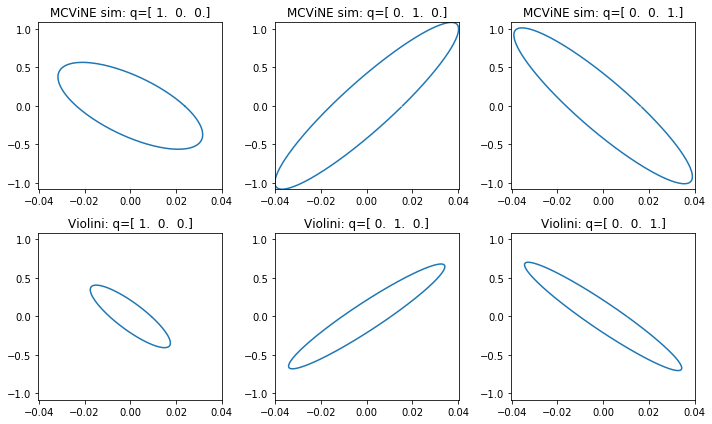

In [85]:
mcvine_InvCov4D = np.linalg.inv(mcvine_cms.values()[0])
violini_InvCov4D = np.linalg.inv(computeCovMat(E, hkl, *optimized.x))

mcvine_ellpsoids = computeEllipsoids(mcvine_InvCov4D)
violini_ellpsoids = computeEllipsoids(violini_InvCov4D)

# find ranges
us = np.vstack([u for _, (_i, u) in mcvine_ellpsoids+violini_ellpsoids])
qs = us[:,0]; Es = us[:, 1]
qmin = np.min(qs); qmax = np.max(qs)
Emin = np.min(Es); Emax = np.max(Es)

plt.figure(figsize=(10, 6))
for i, (q, (inv_cov, u)) in enumerate(mcvine_ellpsoids):
    plt.subplot(2,3,i+1)
    plt.plot(u[:,0], u[:,1])
    plt.xlim(qmin, qmax)
    plt.ylim(Emin, Emax)
    plt.title('MCViNE sim: q=%s' % (q,))
    continue
for i, (q, (inv_cov, u)) in enumerate(violini_ellpsoids):
    plt.subplot(2,3,i+4)
    plt.plot(u[:,0], u[:,1])
    plt.xlim(qmin, qmax)
    plt.ylim(Emin, Emax)
    plt.title('Violini: q=%s' % (q,))
    continue
plt.tight_layout()
plt.savefig("compare-E_%s,hkl_%s,%s,%s.png" % ((E,)+tuple(hkl)))

In [67]:
ls -l *.png

-rw-r--r-- 1 lj7 users 55798 Jul 10 10:51 compare-E_75.4513657392,hkl_-5.18879850427,0.788109107908,-1.30196020451.png


In [80]:
%%time
for (E,hkl), mcvine_cm in mcvine_cms.items():
    print E,hkl
    mcvine_InvCov4D = np.linalg.inv(mcvine_cm)
    violini_InvCov4D = np.linalg.inv(computeCovMat(E, hkl, *optimized.x))

    mcvine_ellpsoids = computeEllipsoids(mcvine_InvCov4D)
    violini_ellpsoids = computeEllipsoids(violini_InvCov4D)

    # find ranges
    us = np.vstack([u for _, (_i, u) in mcvine_ellpsoids+violini_ellpsoids])
    qs = us[:,0]; Es = us[:, 1]
    qmin = np.min(qs); qmax = np.max(qs)
    Emin = np.min(Es); Emax = np.max(Es)
    
    # plot
    plt.figure(figsize=(10, 6))
    for i, (q, (inv_cov, u)) in enumerate(mcvine_ellpsoids):
        plt.subplot(2,3,i+1)
        plt.plot(u[:,0], u[:,1])
        plt.xlim(qmin, qmax)
        plt.ylim(Emin, Emax)
        plt.title('MCViNE sim: q=%s' % (q,))
        continue
    for i, (q, (inv_cov, u)) in enumerate(violini_ellpsoids):
        plt.subplot(2,3,i+4)
        plt.plot(u[:,0], u[:,1])
        plt.title('Violini: q=%s' % (q,))
        plt.xlim(qmin, qmax)
        plt.ylim(Emin, Emax)
        continue
        
    plt.tight_layout()
    plt.savefig("compare-E_%s,hkl_%s,%s,%s.png" % ((E,)+tuple(hkl)))
    plt.close()
    continue

In [69]:
print optimized.x

[  1.78464163e+01   2.56346351e+00   1.56803922e-01   1.74443554e-02
   3.23998256e-03   1.58475081e-03   5.72361419e-03]
